In [2]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.append(project_root)


In [3]:

from examples.mia.cifar.utils.cifar_data_preparation import get_cifar10_dataloader, get_cifar100_dataloader
from examples.mia.cifar.utils.cifar_model_preparation import ResNet18, create_trained_model_and_metadata


# Generate the dataset and dataloaders
path = os.path.join(os.getcwd(), "data/")

# Generate the dataset and dataloaders
path = os.path.join(os.getcwd(), "data/")

In [4]:
train_loader_10, test_loader_10 = get_cifar10_dataloader(path)
train_loader_100, test_loader_100= get_cifar100_dataloader(path)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Train the model
if not os.path.exists("target"):
    os.makedirs("target")
model = ResNet18(num_classes=10)
train_acc, train_loss, test_acc, test_loss = create_trained_model_and_metadata(model, 
                                                                               train_loader_10, 
                                                                               test_loader_10, 
                                                                               epochs=2)

/home/fazeleh/miniconda3/envs/leakpro_test/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fazeleh/miniconda3/envs/leakpro_test/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Training Progress: 100%|██████████| 2/2 [00:03<00:00,  1.83s/it]


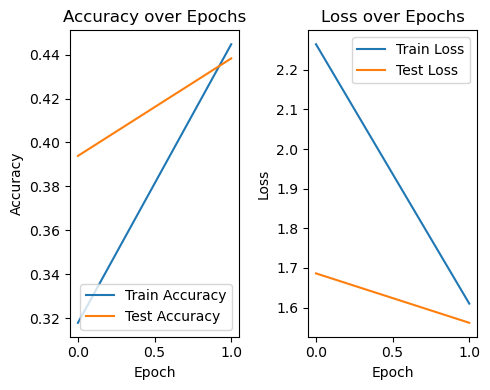

In [6]:
import matplotlib.pyplot as plt

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
from cifar_handler import CifarInputHandler

from leakpro import LeakPro

# Read the config file
config_path = "audit.yaml"

# Prepare leakpro object
leakpro = LeakPro(CifarInputHandler, config_path)

# Run the audit 
leakpro.run_audit()

2024-10-15 11:10:12,281 INFO     Target model blueprint created from ResNet18 in ./utils/cifar_model_preparation.py.
2024-10-15 11:10:12,283 INFO     Loaded target model metadata from ./target/model_metadata.pkl


/home/fazeleh/miniconda3/envs/leakpro_test/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fazeleh/miniconda3/envs/leakpro_test/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
2024-10-15 11:10:12,414 INFO     Loaded target model from ./target


{'audit': {'random_seed': 1234, 'attack_list': {'rmia': {'training_data_fraction': 0.5, 'attack_data_fraction': 0.5, 'num_shadow_models': 3, 'online': True, 'temperature': 2, 'gamma': 2.0, 'offline_a': 0.33, 'offline_b': 0.66}, 'qmia': {'training_data_fraction': 1.0, 'epochs': 5}, 'population': {'attack_data_fraction': 1.0}, 'lira': {'training_data_fraction': 0.5, 'num_shadow_models': 8, 'online': False, 'fixed_variance': True, 'boosting': True}, 'loss_traj': {'training_distill_data_fraction': 0.7, 'number_of_traj': 10, 'label_only': False, 'mia_classifier_epochs': 100}}, 'output_dir': './leakpro_output', 'attack_type': 'mia', 'modality': 'image'}, 'target': {'module_path': './utils/cifar_model_preparation.py', 'model_class': 'ResNet18', 'target_folder': './target', 'data_path': './data/cifar10.pkl'}, 'shadow_model': None, 'distillation_model': None}


2024-10-15 11:10:13,153 INFO     Loaded population dataset from ./data/cifar10.pkl
2024-10-15 11:10:13,154 INFO     Loaded population dataset from ./data/cifar10.pkl
2024-10-15 11:10:13,154 INFO     Creating shadow model handler singleton
2024-10-15 11:10:13,155 INFO     Creating distillation model handler singleton
2024-10-15 11:10:13,156 INFO     Configuring RMIA attack
2024-10-15 11:10:13,156 INFO     Added attack: rmia
2024-10-15 11:10:13,156 INFO     Configuring the QMIA attack
2024-10-15 11:10:13,182 INFO     Added attack: qmia
2024-10-15 11:10:13,182 INFO     Configuring the Population attack
2024-10-15 11:10:13,183 INFO     Added attack: population
2024-10-15 11:10:13,183 INFO     Added attack: lira
2024-10-15 11:10:13,183 INFO     Configuring Loss trajecatory attack
2024-10-15 11:10:13,184 INFO     Added attack: loss_traj
2024-10-15 11:10:13,185 INFO     Preparing attack: rmia
2024-10-15 11:10:13,185 INFO     Preparing shadow models for RMIA attack
2024-10-15 11:10:13,185 INFO

RuntimeError: 0D or 1D target tensor expected, multi-target not supported